# Setup

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
pd.set_option('display.max_rows', 10)
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.transforms as mtransforms
plt.rcParams['figure.figsize'] = [16, 5]
pal = plt.get_cmap('Paired').colors

import quandl

In [219]:
from utils import *

In [4]:
# api_key = open(file='quandl_api').read().replace('\n', '')
# quandl.ApiConfig.api_key = api_key
tickers, prices = get_quandl_sharadar(free=True)

In [5]:
prices

,,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated
Ticker,Date,,,,,,,,
AAPL,1998-12-31,1.446,1.478,1.411,1.462,67922400.0,0.0,40.94,2018-06-19
AXP,1998-12-31,34.967,35.100,34.100,34.167,2528700.0,0.0,102.50,2018-02-11
BA,1998-12-31,31.750,33.130,31.630,32.630,7343500.0,0.0,32.63,2018-02-11
CAT,1998-12-31,23.000,23.940,23.000,23.000,4147400.0,0.0,46.00,2018-02-11
CSCO,1998-12-31,23.220,23.500,22.953,23.250,29021600.0,0.0,93.00,2018-02-11
...,...,...,...,...,...,...,...,...,...
UNH,2018-07-10,254.180,256.900,253.750,255.540,1977592.0,0.0,255.54,2018-07-10
UTX,2018-07-10,126.840,128.170,126.555,127.060,3063885.0,0.0,127.06,2018-07-10
VZ,2018-07-10,50.800,51.420,50.740,51.340,9458492.0,0.0,51.34,2018-07-10


# Finding the trend in a single price

See An introduction to smoothing time series in python, [part 1](http://www.nehalemlabs.net/prototype/blog/2013/04/05/an-introduction-to-smoothing-time-series-in-python-part-i-filtering-theory/) and [part 2](http://www.nehalemlabs.net/prototype/blog/2013/04/09/an-introduction-to-smoothing-time-series-in-python-part-ii-wiener-filter-and-smoothing-splines/).

Series to check:

* AKTC

4912 days.


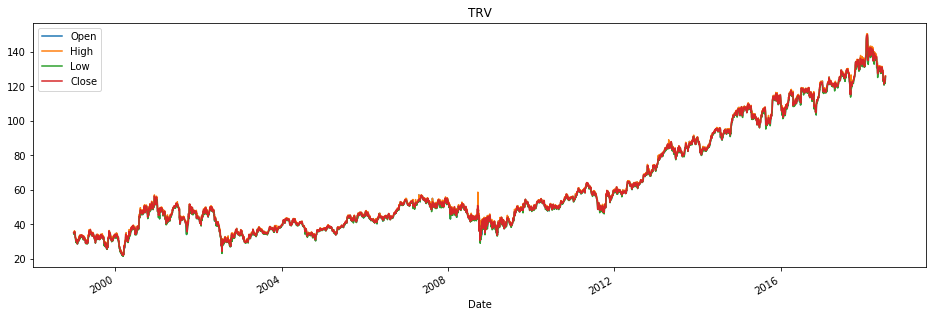

In [6]:
ticker = np.random.choice(tickers)
price = prices.loc[ticker]
print(len(price), 'days.')
price[['Open', 'High', 'Low', 'Close']].plot()
plt.title(ticker);

## Filters

In [7]:
from scipy.interpolate import UnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
import scipy.optimize as op

### Linear 

In [8]:
N = 61
f_sma = np.ones(N) / N

### Gaussian

In [9]:
N_ga = 151
f_ga = gaussian(N_ga, std=20.)
f_ga = f_ga / f_ga.sum()

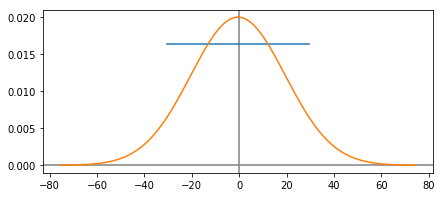

In [10]:
plt.figure(figsize=(7, 3))
plt.axhline(c='grey')
plt.axvline(c='grey')
plt.plot(np.arange(-N/2, N/2), f_sma, label='f_sma')
plt.plot(np.arange(-N_ga/2, N_ga/2), f_ga, label='f_ga')
plt.show()

### Wiener 

In [11]:
sigma = np.std(price.Close)
f_wi = lambda x: wiener(x, mysize=N, noise=sigma)

### Spline

In [12]:
f_sp = lambda x: UnivariateSpline(np.arange(len(x)), x)(np.arange(len(x)))

### Results

<Figure size 1152x432 with 0 Axes>

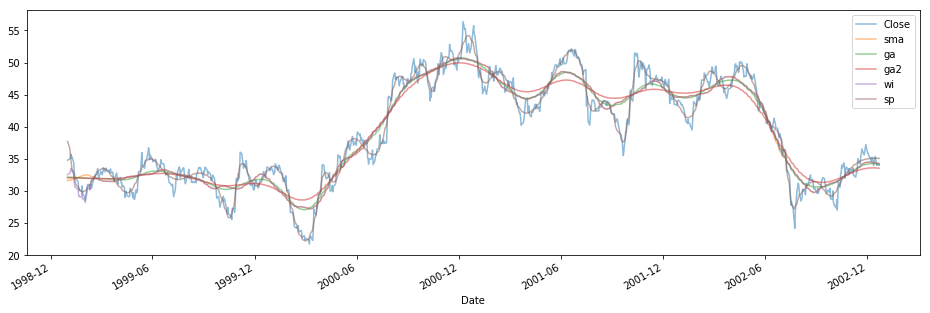

In [49]:
plt.figure(figsize=(16, 6))
results = price[['Close']].assign(sma=filters.convolve1d(price.Close, f_sma),
                                  ga=filters.convolve1d(price.Close, f_ga),
                                  ga2=filters.convolve1d(filters.convolve1d(price.Close, f_ga), f_ga),
                                  wi=f_wi(price.Close),
                                  sp=f_sp(price.Close))
results[:1000].plot(alpha=0.5);

<Figure size 1152x432 with 0 Axes>

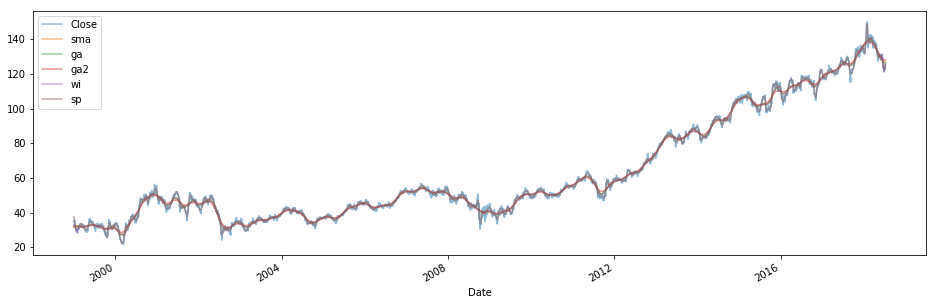

In [48]:
plt.figure(figsize=(16, 6));
results.plot(alpha = 0.5);

In [45]:
def smooth_price(df, N=151, std=20.):
    f_ga = gaussian(N_ga, std=std)
    f_ga = f_ga / f_ga.sum()
    df = df.assign(Smoothed=filters.convolve1d(df.Close, f_ga))
    
    return df

## Trends 

### Peaks and Valleys

In [191]:
from scipy.signal import find_peaks, find_peaks_cwt
from sklearn.metrics import confusion_matrix

In [192]:
results = smooth_price(price)

In [193]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Smoothed
Date,,,,,,,,,
1998-12-31,35.00,35.13,34.56,34.81,406900.0,0.0,34.81,2018-02-11,32.171635
1999-01-04,34.75,35.31,34.75,35.00,432200.0,0.0,35.00,2018-02-11,32.170244
1999-01-05,34.13,35.63,34.00,35.25,727400.0,0.0,35.25,2018-02-11,32.167464
1999-01-06,35.25,36.13,35.06,35.75,767200.0,0.0,35.75,2018-02-11,32.163316
1999-01-07,35.50,35.50,34.63,35.13,440900.0,0.0,35.13,2018-02-11,32.157862
...,...,...,...,...,...,...,...,...,...
2018-07-03,123.07,124.05,122.64,122.77,658770.0,0.0,122.77,2018-07-03,126.530960
2018-07-05,123.43,123.49,121.81,122.60,1285828.0,0.0,122.60,2018-07-05,126.496677
2018-07-06,122.61,123.80,121.82,123.18,1006323.0,0.0,123.18,2018-07-06,126.470834


In [194]:
results = results.assign(Trend=np.nan, Max_Drawdown=np.nan)
peaks, _ = find_peaks(results.Smoothed)
valleys, _ = find_peaks(-results.Smoothed)

In [195]:
n_changes = min(len(peaks), len(valleys))
assert len(set(np.sign(peaks[:n_changes] - valleys[:n_changes]))) == 1

In [196]:
# End
if valleys.max() > peaks.max():
    peaks = np.concatenate((peaks, np.ones(1, dtype=np.int32) * len(results) - 1))
else:
    valleys = np.concatenate((valleys, np.ones(1, dtype=np.int32) * len(results) - 1))

In [197]:
peaks

array([  35,  109,  238,  488,  617,  718,  815,  991, 1127, 1292, 1535,
       1752, 2013, 2107, 2234, 2345, 2509, 2740, 2822, 3106, 3604, 3754,
       3896, 4068, 4176, 4255, 4349, 4429, 4666, 4813])

> TO DO: Checks.

In [198]:
results.loc[results.index[peaks], 'Trend'] = 1
results.loc[results.index[valleys], 'Trend'] = -1
results.Trend.fillna(method='bfill', inplace=True)

In [199]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Smoothed,Trend,Max_Drawdown
Date,,,,,,,,,,,
1998-12-31,35.00,35.13,34.56,34.81,406900.0,0.0,34.81,2018-02-11,32.171635,-1.0,NaN
1999-01-04,34.75,35.31,34.75,35.00,432200.0,0.0,35.00,2018-02-11,32.170244,-1.0,NaN
1999-01-05,34.13,35.63,34.00,35.25,727400.0,0.0,35.25,2018-02-11,32.167464,-1.0,NaN
1999-01-06,35.25,36.13,35.06,35.75,767200.0,0.0,35.75,2018-02-11,32.163316,-1.0,NaN
1999-01-07,35.50,35.50,34.63,35.13,440900.0,0.0,35.13,2018-02-11,32.157862,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2018-07-03,123.07,124.05,122.64,122.77,658770.0,0.0,122.77,2018-07-03,126.530960,-1.0,NaN
2018-07-05,123.43,123.49,121.81,122.60,1285828.0,0.0,122.60,2018-07-05,126.496677,-1.0,NaN
2018-07-06,122.61,123.80,121.82,123.18,1006323.0,0.0,123.18,2018-07-06,126.470834,-1.0,NaN


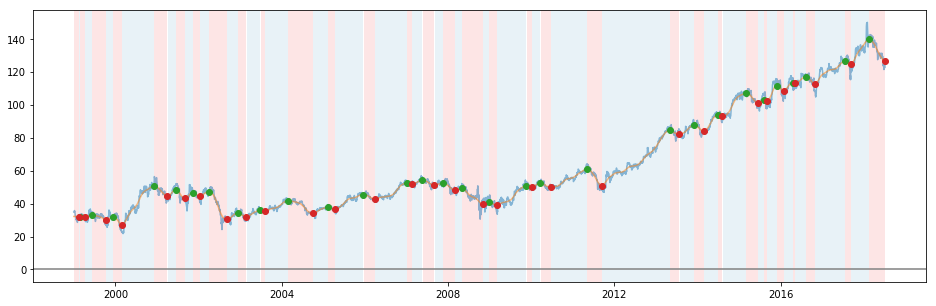

In [200]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

### Slopes

In [201]:
results = results.assign(Trend2=results.Smoothed.pct_change().apply(np.sign))
results.loc[results.index[0], 'Trend2'] = results.Trend2[1]

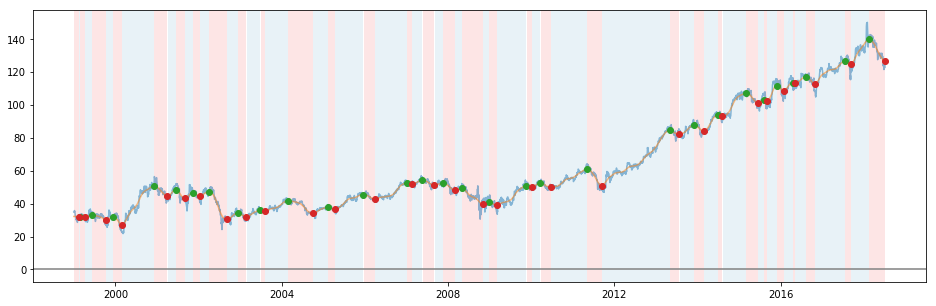

In [202]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend2 up')
ax.fill_between(results.index, 0, results.Trend2.max(), where= results.Trend2 < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend2 down')
plt.plot(results['Close'], alpha = 0.5)
plt.plot(results['Smoothed'], alpha = 0.5)
plt.plot(results.iloc[peaks]['Smoothed'], 'o', label='peaks')
plt.plot(results.iloc[valleys]['Smoothed'], 'o', label='valleys')
plt.axhline(0, c='grey')
plt.show()

In [203]:
confusion_matrix(results.Trend.values, results.Trend2) / len(results)

array([[0.37296417, 0.        ],
       [0.        , 0.62703583]])

> Both methods are equivalent!!

## Max drawdown within trend

-> For trailing stop-loss orders...

In [204]:
breakpoints = np.concatenate((np.zeros(1, dtype=np.int32), peaks + 1, valleys + 1))
breakpoints.sort()
print('Breakpoints:', breakpoints)

Breakpoints: [   0   33   36   66  110  197  239  293  489  568  618  673  719  761
  816  923  992 1042 1128 1154 1293 1445 1536 1579 1753 1819 2014 2045
 2108 2181 2235 2306 2346 2474 2510 2556 2741 2771 2823 2886 3107 3196
 3605 3665 3755 3811 3897 3926 4069 4140 4177 4194 4256 4296 4350 4365
 4430 4486 4667 4702 4814 4912]


In [205]:
b = 3
trend_start = breakpoints[b - 1]
trend_end = breakpoints[b]
res_b = results[trend_start:trend_end]
res_b

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Smoothed,Trend,Max_Drawdown,Trend2
Date,,,,,,,,,,,,
1999-02-24,33.38,33.75,32.19,32.38,408700.0,0.0,32.38,2018-02-11,31.947350,-1.0,NaN,-1.0
1999-02-25,32.25,32.50,31.38,32.13,357100.0,0.0,32.13,2018-02-11,31.947094,-1.0,NaN,-1.0
1999-02-26,32.00,32.50,31.75,32.38,277700.0,0.0,32.38,2018-02-11,31.946439,-1.0,NaN,-1.0
1999-03-01,32.38,33.13,32.13,33.06,442900.0,0.0,33.06,2018-02-11,31.945276,-1.0,NaN,-1.0
1999-03-02,33.00,33.13,32.38,32.88,435300.0,0.0,32.88,2018-02-11,31.943464,-1.0,NaN,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1999-03-31,32.25,32.31,31.00,31.06,662700.0,0.0,31.06,2018-02-11,31.751372,-1.0,NaN,-1.0
1999-04-01,31.06,32.88,31.06,31.88,732400.0,0.0,31.88,2018-02-11,31.744223,-1.0,NaN,-1.0
1999-04-05,31.94,32.38,31.94,32.13,399800.0,0.0,32.13,2018-02-11,31.738746,-1.0,NaN,-1.0


In [206]:
for b in range(1, len(breakpoints)):

    trend_start = breakpoints[b - 1]
    trend_end = breakpoints[b]
    res_b = results[trend_start:trend_end]
    trend_b = res_b.Trend[0]

    # Adjust for position (long, short)
    close_b = res_b.Close[0] * res_b.Close.pct_change()[1:].mul(trend_b).add(1).cumprod()  
    close_b[res_b.index[0]] = res_b.Close[0]
    close_b = close_b.sort_index()

    peak = close_b[0]
    low = peak
    drawdown = 0
    max_drawdown = 0

    for i in range(1, len(close_b)):
        # Max drawdown
        if close_b[i] > peak:
            peak = close_b[i]
            low = peak
        if close_b[i] < low:
            low = close_b[i]
            drawdown = low / peak - 1
        max_drawdown = min(drawdown, max_drawdown)
    
    results.loc[res_b.index, 'Max_Drawdown'] = -max_drawdown
    

In [207]:
results

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Smoothed,Trend,Max_Drawdown,Trend2
Date,,,,,,,,,,,,
1998-12-31,35.00,35.13,34.56,34.81,406900.0,0.0,34.81,2018-02-11,32.171635,-1.0,0.125646,-1.0
1999-01-04,34.75,35.31,34.75,35.00,432200.0,0.0,35.00,2018-02-11,32.170244,-1.0,0.125646,-1.0
1999-01-05,34.13,35.63,34.00,35.25,727400.0,0.0,35.25,2018-02-11,32.167464,-1.0,0.125646,-1.0
1999-01-06,35.25,36.13,35.06,35.75,767200.0,0.0,35.75,2018-02-11,32.163316,-1.0,0.125646,-1.0
1999-01-07,35.50,35.50,34.63,35.13,440900.0,0.0,35.13,2018-02-11,32.157862,-1.0,0.125646,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-03,123.07,124.05,122.64,122.77,658770.0,0.0,122.77,2018-07-03,126.530960,-1.0,0.036430,-1.0
2018-07-05,123.43,123.49,121.81,122.60,1285828.0,0.0,122.60,2018-07-05,126.496677,-1.0,0.036430,-1.0
2018-07-06,122.61,123.80,121.82,123.18,1006323.0,0.0,123.18,2018-07-06,126.470834,-1.0,0.036430,-1.0


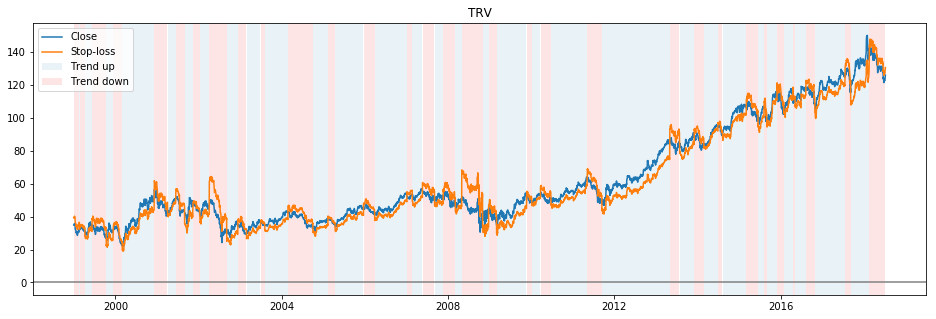

In [208]:
fig, ax = plt.subplots(figsize=(16, 5))
trans = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend > 0, facecolor=pal[0],
                        alpha=0.25, transform=trans, label='Trend up')
ax.fill_between(results.index, 0, results.Trend.max(), where= results.Trend < 0, facecolor=pal[4],
                alpha=0.25, transform=trans, label='Trend down')
plt.plot(results.Close, label='Close')
plt.plot(results.Close * (1 - results.Max_Drawdown * results.Trend), label='Stop-loss')
plt.axhline(0, c='grey')
plt.legend()
plt.title(ticker)
plt.show()

In [209]:
res2 = find_trends(price)
assert res2.equals(results.drop('Trend2', axis=1))

# Sample...

In [266]:
from utils import *
ticker = np.random.choice(tickers)
price = prices.loc[ticker]

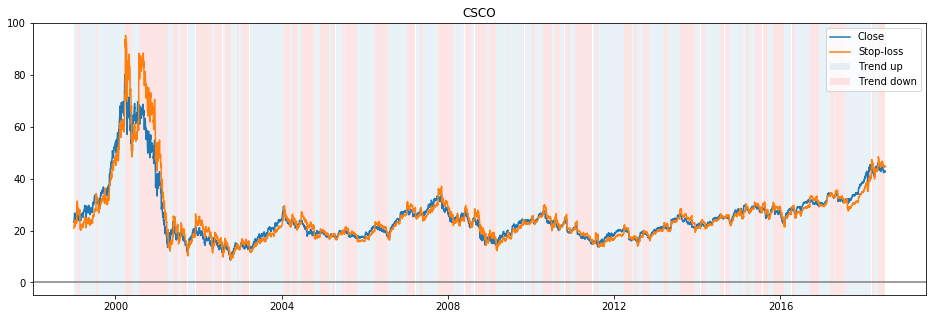

In [267]:
trends = find_trends(price, sd=10.)
plot_trends(trends, ticker)

In [268]:
trends.groupby('n_Trend').Close.count().describe()

count    110.000000
mean      44.654545
std       37.633295
min        3.000000
25%       18.250000
50%       34.000000
75%       52.750000
max      209.000000
Name: Close, dtype: float64

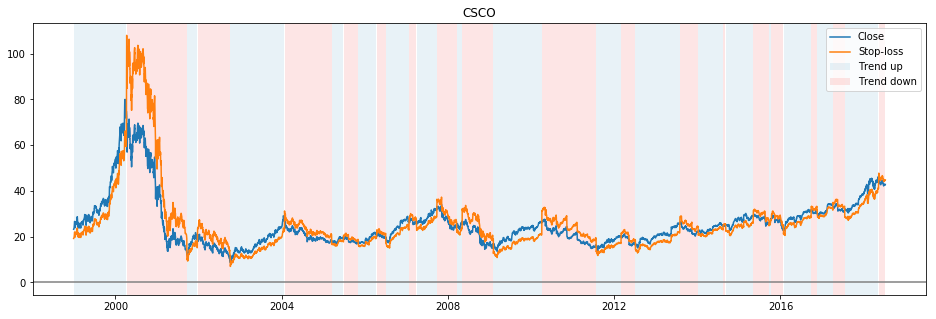

In [269]:
trends = find_trends(price, sd=30.)
plot_trends(trends, ticker)

In [270]:
trends.groupby('Max_Drawdown').Close.count().describe()

count     34.000000
mean     144.470588
std      100.872928
min       15.000000
25%       71.250000
50%      114.500000
75%      195.750000
max      362.000000
Name: Close, dtype: float64

In [271]:
trends

,Open,High,Low,Close,Volume,Dividends,Closeunadj,Lastupdated,Smoothed,Trend,n_Trend,Max_Drawdown
Date,,,,,,,,,,,,
1998-12-31,23.220,23.500,22.953,23.250,29021600.0,0.00,93.00,2018-02-11,25.633868,1.0,1.0,0.172800
1999-01-04,23.625,24.157,23.345,23.828,62691200.0,0.00,95.31,2018-02-11,25.636068,1.0,1.0,0.172800
1999-01-05,23.953,24.282,23.720,24.235,50396000.0,0.00,96.94,2018-02-11,25.639665,1.0,1.0,0.172800
1999-01-06,24.970,25.375,24.750,24.938,81818000.0,0.00,99.75,2018-02-11,25.643121,1.0,1.0,0.172800
1999-01-07,24.625,26.250,24.515,25.900,95150800.0,0.00,103.60,2018-02-11,25.646267,1.0,1.0,0.172800
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-03,42.935,43.225,42.620,42.670,13465999.0,0.00,42.67,2018-07-03,43.565846,-1.0,34.0,0.045439
2018-07-05,42.560,42.640,41.960,42.560,17371163.0,0.33,42.56,2018-07-05,43.562610,-1.0,34.0,0.045439
2018-07-06,42.390,42.875,42.310,42.710,20120050.0,0.00,42.71,2018-07-06,43.560690,-1.0,34.0,0.045439


# TO DO:

* Asset selection.
  * By small or negative change correlations.
  * Highest signal to noise ratios (see Kaufman, 2005, pp. 870).
* Exit by volume (~extreme reduction, bankrupt, ...).